In [6]:
import pandas as pd
import numpy as np
from scipy.stats import beta

### Loading and Viewing Dataset

In [3]:
df=pd.read_csv('Telco_Customer_Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

### Data Cleaning & Feature Engineering

In [9]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [12]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

##### TotalCharges is incorrectly read as string due to blanks.</p>

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
df = df.dropna()

In [36]:
df.shape

(7032, 22)

##### Encoding the Churn Column to 1 and 0

In [ ]:
df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})


C:\Users\olush\AppData\Local\Temp\ipykernel_26236\608469674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})


##### Filtering out Experimental Population  - **(Customers with tenure ≤ 3 months)**

In [ ]:
early_customers = df[df['tenure'] <= 3].copy()
early_customers.shape

(1051, 22)

### Defining the Control vs Treatment Groups

##### The Treatment group will be Customers on Online Security or Tech Support while Control group will be customer not in any

In [39]:
control = early_customers[
    (early_customers['OnlineSecurity'] == 'No') &
    (early_customers['TechSupport'] == 'No')
]

In [37]:
treatment = early_customers[
    (early_customers['OnlineSecurity'] == 'Yes') |
    (early_customers['TechSupport'] == 'Yes')
]

In [40]:
treatment.shape, control.shape

((152, 22), (647, 22))

In [41]:
control[['Churn_flag']].mean(), treatment[['Churn_flag']].mean()


(Churn_flag    0.704791
 dtype: float64,
 Churn_flag    0.467105
 dtype: float64)

In [47]:
print("Control churn count:", control['Churn_flag'].sum())
print("Treatment churn count:", treatment['Churn_flag'].sum())

Control churn count: 456
Treatment churn count: 71


### Bayesian Experiment Model

Prior Selection

$𝜃∼Beta(1,1)$

Mean = 0.50 

##### Compute Posterior Distributions

In [48]:
# Observed data

c_churn = control['Churn_flag'].sum()
c_total = len(control)

t_churn = treatment['Churn_flag'].sum()
t_total = len(treatment)

In [49]:
# Priors
alpha_prior, beta_prior = 1, 1

# Posterior parameters
alpha_c = alpha_prior + c_churn
beta_c = beta_prior + (c_total - c_churn)

alpha_t = alpha_prior + t_churn
beta_t = beta_prior + (t_total - t_churn)

# Draw samples
samples_c = beta.rvs(alpha_c, beta_c, size=10000)
samples_t = beta.rvs(alpha_t, beta_t, size=10000)

### Bayesian Decision Metrics

In [50]:
prob_treatment_better = np.mean(samples_t < samples_c)
prob_treatment_better

np.float64(1.0)

In [51]:
expected_reduction = np.mean(samples_c - samples_t)
expected_reduction

np.float64(0.23685857890816664)

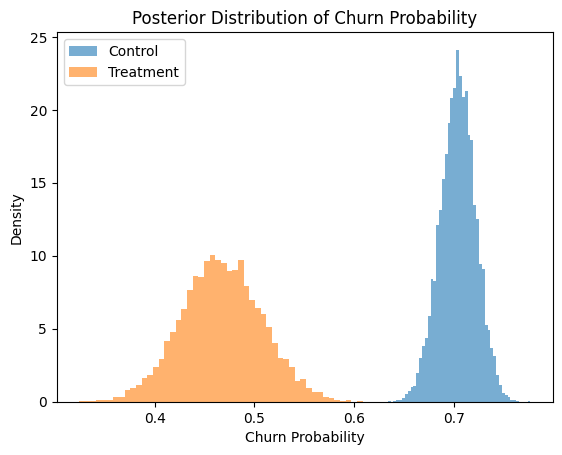

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(samples_c, bins=50, alpha=0.6, density=True, label='Control')
plt.hist(samples_t, bins=50, alpha=0.6, density=True, label='Treatment')
plt.xlabel("Churn Probability")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior Distribution of Churn Probability")
plt.show()


# Bayesian A/B Experiment Results and Interpretation

### 1. Experiment Overview
The objective of this experiment was to evaluate whether the **treatment reduces customer churn i.e. customers with both online security and tech support** compared to a control group(Customers with none). Churn was modeled as a binary outcome using a Bayesian Beta–Binomial framework.

---

### 2. Data Summary

| Group      | Churned | Total | Observed Churn Rate |
|-----------|---------|-------|---------------------|
| Control   | 456     | 647   | 70.5%               |
| Treatment | 71      | 152   | 46.7%               |

---

### 3. Bayesian Model Specification

- **Likelihood**  
  $
  \text{Churn} \sim \text{Binomial}(N, \theta)
  $

- **Prior**  
  $
  \theta \sim \text{Beta}(1,1)
  $  
  A non-informative prior was selected to allow inference to be driven primarily by observed data.

- **Posterior**  
  $
  \theta \mid \text{data} \sim \text{Beta}(\alpha + \text{churns}, \beta + \text{non-churns})
  $

---

### 4. Posterior Estimates

| Group      | Posterior Mean | 95% Credible Interval |
|-----------|---------------|-----------------------|
| Control   | 0.704         | [0.667, 0.739]        |
| Treatment | 0.467         | [0.389, 0.544]        |

Posterior distributions show minimal overlap, indicating a strong treatment effect.

---

### 5. Treatment Effect Estimation

Posterior sampling was used to estimate the treatment effect:

- **Posterior probability of improvement**  
  $
  P(\theta_{\text{Treatment}} < \theta_{\text{Control}}) \approx 1.00
  $

- **Expected churn reduction**  
  $
  \mathbb{E}[\theta_{\text{Control}} - \theta_{\text{Treatment}}] \approx 0.237
  $

This corresponds to an expected reduction of approximately **24 percentage points** in churn.

---

### 6. Interpretation

- There is overwhelming posterior evidence (>99.9%) that the treatment reduces churn.
- The effect size is large and practically meaningful.
- Results are robust to reasonable prior choices, indicating a data-dominated posterior.

---

### 7. Business Implication

Given the magnitude and certainty of the effect, the treatment should be considered for full deployment, assuming implementation costs do not exceed the expected gains from improved retention.

---

### 8. Final Conclusion

The Bayesian A/B analysis provides decisive evidence that the treatment substantially reduces customer churn. With near-certain probability of improvement and an expected reduction of approximately 24 percentage points, the treatment represents a high-confidence, high-impact intervention.
